In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning,ConvergenceWarning

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numpy import where
from sklearn.utils import resample
import eli5
from eli5.sklearn import PermutationImportance

In [5]:
train = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_training-set.csv')
train.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0


In [6]:
dfc = train.copy()

In [7]:
test = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_testing-set.csv')
test.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0


In [8]:
train.shape, test.shape

((175341, 45), (82332, 45))

In [9]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
dfc.drop('id', axis = 1, inplace = True)

In [10]:
df_cat = train.select_dtypes(include = 'object')
df_num = train.select_dtypes(exclude = 'object')

In [11]:
for i in df_cat.columns:
    print(i, df_cat[i].nunique())

proto 133
service 13
state 9
attack_cat 10


In [12]:
warnings.filterwarnings('ignore')

In [13]:
for i in ['proto', 'service', 'state']:
    dic = dict(df_cat.groupby(i)['attack_cat'].count()/df_cat.shape[0])
    df_cat[i] = df_cat[i].map(dic)
df_cat

,proto,service,state,attack_cat
0,0.455946,0.537056,0.443849,Normal
1,0.455946,0.537056,0.443849,Normal
2,0.455946,0.537056,0.443849,Normal
3,0.455946,0.019550,0.443849,Normal
4,0.455946,0.537056,0.443849,Normal
...,...,...,...,...
175336,0.360914,0.269726,0.469229,Generic
175337,0.455946,0.537056,0.443849,Shellcode
175338,0.360914,0.269726,0.469229,Generic
175339,0.360914,0.269726,0.469229,Generic


In [14]:
df_cat['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [15]:
atk_lab = {'Normal' : 0, 'Generic' : 1, 'Exploits' : 2, 'Fuzzers' : 3, 'DoS' : 4, 'Reconnaissance' : 5,
          'Analysis' : 6, 'Backdoor' : 7, 'Shellcode' : 8, 'Worms' : 9}
df_cat['attack_label'] = df_cat['attack_cat'].map(atk_lab)

In [16]:
for i in ['proto', 'service', 'state']:
    dic = dict(test.groupby(i)['attack_cat'].count()/test.shape[0])
    test[i] = test[i].map(dic)
test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,0.357309,0.572718,0.414942,2,0,496,0,90909.090200,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,0.357309,0.572718,0.414942,2,0,1762,0,125000.000300,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,0.357309,0.572718,0.414942,2,0,1068,0,200000.005100,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,0.357309,0.572718,0.414942,2,0,900,0,166666.660800,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,0.357309,0.572718,0.414942,2,0,2126,0,100000.002500,254,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,0.357309,0.572718,0.414942,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,0.523430,0.572718,0.477809,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


In [17]:
test['attack_label'] = test['attack_cat'].map(atk_lab)
test.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_label
0,0.000011,0.357309,0.572718,0.414942,2,0,496,0,90909.0902,254,...,2,0,0,0,1,2,0,Normal,0,0
1,0.000008,0.357309,0.572718,0.414942,2,0,1762,0,125000.0003,254,...,2,0,0,0,1,2,0,Normal,0,0


In [18]:
df = pd.concat([df_num, df_cat], axis = 1)
df.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0,1,1,0,0,0.455946,0.537056,0.443849,Normal,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0,1,6,0,0,0.455946,0.537056,0.443849,Normal,0


## -----------------------------------------------------------------------------

In [19]:
print(atk_lab)

{'Normal': 0, 'Generic': 1, 'Exploits': 2, 'Fuzzers': 3, 'DoS': 4, 'Reconnaissance': 5, 'Analysis': 6, 'Backdoor': 7, 'Shellcode': 8, 'Worms': 9}


In [20]:
df['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [21]:
df['attack_label'] = df['attack_label'].replace({4 : 3, 8 : 2, 9 : 2, 7 : 5, 6 : 5})
test['attack_label'] = test['attack_label'].replace({4 : 3, 8 : 2, 9 : 2, 7 : 5, 6 : 5})

In [22]:
df['attack_label'] = df['attack_label'].replace({5:4})
test['attack_label'] = test['attack_label'].replace({5:4})

In [23]:
df['attack_label'].value_counts()

0    56000
1    40000
2    34656
3    30448
4    14237
Name: attack_label, dtype: int64

In [24]:
Xtrain = df.drop(['attack_cat', 'attack_label', 'label'], axis = 1)
Ytrain = df['attack_label']
Xtest = test.drop(['attack_cat', 'attack_label', 'label'], axis = 1)
Ytest = test['attack_label']

In [25]:
Xtr_cols = Xtrain.columns
Xtest = Xtest.loc[:, Xtr_cols]

In [26]:
Xtrain.shape, Xtest.shape

((175341, 42), (82332, 42))

## -------------------------------------------------------------------------------------------

In [27]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(Xtrain, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
ypred_train = xgb.predict(Xtrain)
ypred_test = xgb.predict(Xtest)

In [29]:
print('Train')
print(classification_report(Ytrain, ypred_train))
print('_'*70)
print('Test')
print(classification_report(Ytest, ypred_test))

Train
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     56000
           1       1.00      0.99      0.99     40000
           2       0.68      0.90      0.77     34656
           3       0.72      0.60      0.66     30448
           4       0.95      0.63      0.76     14237

    accuracy                           0.86    175341
   macro avg       0.86      0.81      0.83    175341
weighted avg       0.87      0.86      0.86    175341

______________________________________________________________________
Test
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     37000
           1       1.00      0.97      0.98     18871
           2       0.62      0.83      0.71     11554
           3       0.35      0.46      0.40     10151
           4       0.53      0.67      0.60      4756

    accuracy                           0.78     82332
   macro avg       0.69      0.74      0.71     8

In [27]:
over = SMOTE(sampling_strategy = {4 : 18000})
X, y = over.fit_resample(Xtrain, Ytrain)
y.value_counts()

0    56000
1    40000
2    34656
3    30448
4    18000
Name: attack_label, dtype: int64

In [28]:
under = RandomUnderSampler(sampling_strategy = {0 : 50000, 1 : 35000, 2 : 30000, 3 : 26000})
X, y = under.fit_resample(X, y)
y.value_counts()

0    50000
1    35000
2    30000
3    26000
4    18000
Name: attack_label, dtype: int64

In [29]:
df_smpl = pd.concat([X,y], axis = 1)

In [30]:
df_smpl = resample(df_smpl, n_samples = 50000)

In [31]:
Xs = df_smpl.drop('attack_label', axis = 1)
Ys = df_smpl['attack_label']

In [35]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(Xs, Ys)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
ypred_train = xgb.predict(Xs)
ypred_test = xgb.predict(Xtest)

In [37]:
print('Train')
print(classification_report(Ys, ypred_train))
print('_'*70)
print('Test')
print(classification_report(Ytest, ypred_test))

Train
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     15739
           1       1.00      0.99      1.00     10948
           2       0.69      0.94      0.79      9457
           3       0.81      0.65      0.72      8186
           4       0.96      0.70      0.81      5670

    accuracy                           0.88     50000
   macro avg       0.89      0.85      0.86     50000
weighted avg       0.90      0.88      0.88     50000

______________________________________________________________________
Test
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       1.00      0.97      0.98     18871
           2       0.65      0.77      0.70     11554
           3       0.33      0.47      0.39     10151
           4       0.44      0.74      0.55      4756

    accuracy                           0.76     82332
   macro avg       0.68      0.74      0.69     8

In [38]:
def modl(modl_nm, X_tr, y_tr, X_ts, y_ts):
    modl_nm.fit(X_tr, y_tr)
    print('Train model')
    ypred_train = modl_nm.predict(X_tr)
    ypred_test = modl_nm.predict(X_ts)
    print(classification_report(y_tr, ypred_train))
    print('_'*70)
    print('Test model')
    print(classification_report(y_ts, ypred_test))

In [39]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

## -------------------------------------------------------------------------------

In [43]:
iner = []
sil = []
tick = []
for i in range(1, 10):
    tick.append(i)
    kmean = KMeans(n_clusters = i, n_init = 20)
    kmean.fit(Xs)
    
    try:
        iner.append(kmean.inertia_)
        sil.append(silhouette_score(Xs, kmean.labels_))
    except:
        iner.append(kmean.inertia_)

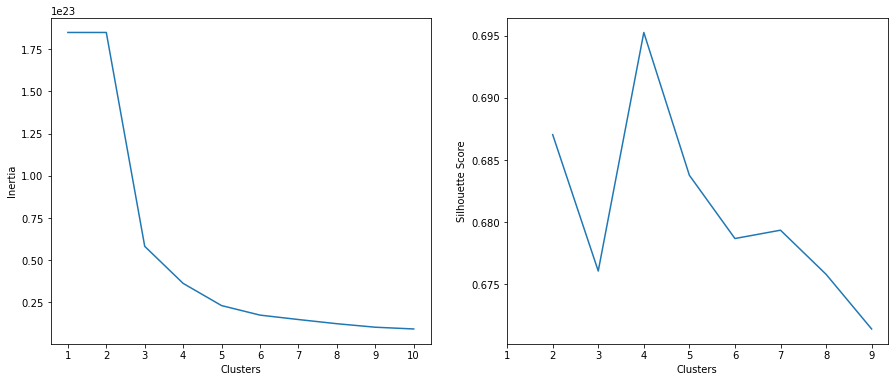

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
ax1.plot(range(1,11), iner)
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Inertia')
ax1.set_xticks(ticks = range(1,11))

ax2.plot(tick[1:], sil)
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(ticks = tick)

plt.show()

In [32]:
Xfs = Xs.loc[:, ['sbytes', 'dbytes', 'sttl', 'dload', 'djit', 'swin', 'dwin', 'tcprtt',
         'smean', 'dmean', 'response_body_len', 'ct_srv_src', 'ct_dst_sport_ltm',
         'ct_dst_src_ltm', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto', 'service']]

In [56]:
iner = []
sil = []
tick = []
for i in range(1, 10):
    tick.append(i)
    kmean = KMeans(n_clusters = i, n_init = 20)
    kmean.fit(Xfs)
    
    try:
        iner.append(kmean.inertia_)
        sil.append(silhouette_score(Xfs, kmean.labels_))
    except:
        iner.append(kmean.inertia_)

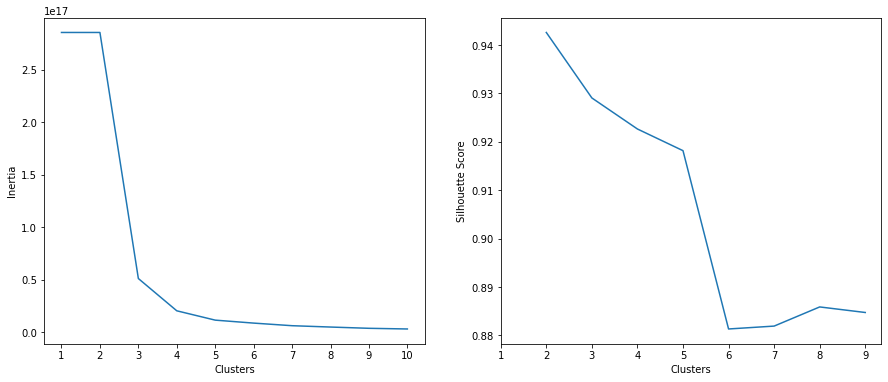

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
ax1.plot(range(1,11), iner)
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Inertia')
ax1.set_xticks(ticks = range(1,11))

ax2.plot(tick[1:], sil)
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(ticks = tick)

plt.show()

In [58]:
def modl(modl_nm, X_tr, y_tr, X_ts, y_ts):
    modl_nm.fit(X_tr, y_tr)
    print('Train model')
    ypred_train = modl_nm.predict(X_tr)
    ypred_test = modl_nm.predict(X_ts)
    print(classification_report(y_tr, ypred_train))
    print('_'*70)
    print('Test model')
    print(classification_report(y_ts, ypred_test))

In [68]:
kmean = KMeans(n_clusters = 5, n_init = 20)
kmean.fit(Xfs)

KMeans(n_clusters=5, n_init=20)

In [69]:
df_X = Xfs.copy()
df_X['label'] = kmean.labels_

In [70]:
Xtr = df_X.drop('label', axis = 1)
Ytr = df_X['label']
Xts = Xtest.loc[:, Xfs.columns]
Yts = Ytest.copy()

In [67]:
Ytr.value_counts()

0    42085
5     4392
2     1446
3      745
1      707
4      625
Name: label, dtype: int64

In [73]:
import lightgbm as lgb

In [ ]:
lgb.LGBMClassifier

In [ ]:
LogisticRegression()

## -------------------------------------------------------------------

In [37]:
xgb = XGBClassifier()
xgb.fit(Xfs, Ys)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
perm = PermutationImportance(xgb, random_state = 0, scoring = 'f1_weighted', n_iter = 10).fit(Xfs, Ys)
eli5.show_weights(perm, feature_names = Xfs.columns.tolist())

Weight,Feature
0.2628 ± 0.0043,sttl
0.2501 ± 0.0029,sbytes
0.0590 ± 0.0015,smean
0.0383 ± 0.0017,proto
0.0349 ± 0.0011,dbytes
0.0330 ± 0.0020,service
0.0251 ± 0.0022,ct_srv_dst
0.0248 ± 0.0017,tcprtt
0.0231 ± 0.0023,ct_srv_src
0.0225 ± 0.0012,ct_dst_sport_ltm


In [39]:
Xts = Xtest.loc[:, Xfs.columns]
Yts = Ytest.copy()

In [40]:
perm = PermutationImportance(xgb, random_state = 0, scoring = 'f1_weighted', n_iter = 10).fit(Xts, Yts)
eli5.show_weights(perm, feature_names = Xts.columns.tolist())

Weight,Feature
0.2054 ± 0.0028,sttl
0.1666 ± 0.0012,sbytes
0.0576 ± 0.0011,service
0.0420 ± 0.0011,smean
0.0238 ± 0.0009,ct_dst_src_ltm
0.0232 ± 0.0019,dbytes
0.0194 ± 0.0010,tcprtt
0.0132 ± 0.0006,ct_dst_sport_ltm
0.0119 ± 0.0007,ct_srv_dst
0.0112 ± 0.0008,dmean


In [41]:
train['dinpkt'].nunique()

74245

In [42]:
train['stcpb'].nunique()

75265

In [43]:
train['sttl'].nunique()

11

In [44]:
train['sbytes'].nunique()

7214

In [46]:
l20 = []
r20500 = []
u500 = []
for i in train.columns:
    print(i, train[i].nunique())
    if(train[i].nunique() < 20):
        l20.append([i, train[i].nunique()])
    elif(train[i].nunique() < 500):
        r20500.append([i, train[i].nunique()])
    else:
        u500.append([i, train[i].nunique()])

dur 74039
proto 133
service 13
state 9
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
ct_srv_src 52
ct_state_ttl 5
ct_dst_ltm 50
ct_src_dport_ltm 47
ct_dst_sport_ltm 32
ct_dst_src_ltm 54
is_ftp_login 4
ct_ftp_cmd 4
ct_flw_http_mthd 11
ct_src_ltm 50
ct_srv_dst 52
is_sm_ips_ports 2
attack_cat 10
label 2


In [47]:
len(l20), len(r20500), len(u500)

(14, 12, 18)

In [33]:
df_fs = pd.concat([Xs, Ys], axis = 1)

In [37]:
df_fs.to_csv('caps.csv', index = False)